# Project : Drones
The following notebook is dedicated to deep learning. I will use the pyTorch to create ResNet50 classifier that can identify drones in the picture.  
## Importing the Libraries and defining constants

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.core.pylabtools import figsize
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

In [2]:
# Paths for training and testing data
traindir="training_dataset"
testdir="testing_dataset"
dronai = os.path.join("training_dataset/",'drones')
non_drone = os.path.join("training_dataset/",'not_drones')

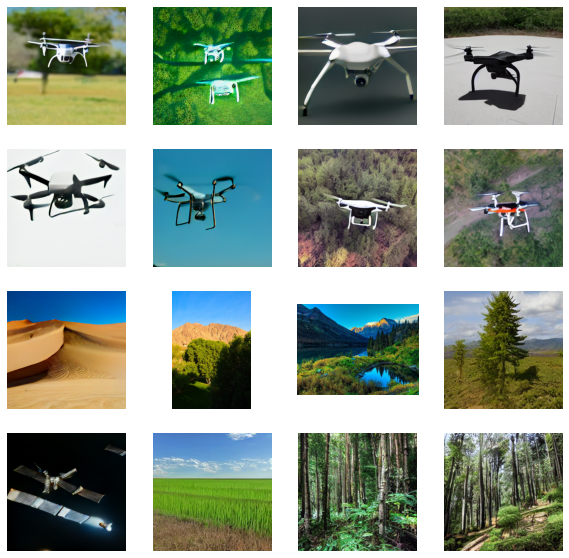

In [3]:
# Let's take a look at the training data ( take 8 photos from each folder [drones and non_drones])
samples_pos = [os.path.join(dronai,np.random.choice(os.listdir(dronai),1)[0]) for _ in range(8)]
samples_neg = [os.path.join(non_drone,np.random.choice(os.listdir(non_drone),1)[0]) for _ in range(8)]

nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
  if i < 8:
    pic = plt.imread(samples_pos[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
  else:
    pic = plt.imread(samples_neg[i%8])
    ax[i].imshow(pic)
    ax[i].set_axis_off()
plt.show()

## Pre-processing the data
Here we define transformations that will be applied to the training and test sets

In [4]:
#  pre-processinimo steps for training 
# (Mandatory steps: Resize -> ToTensor -> Normalization)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# test transforms
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:
# Create datesets from the images that are stored in the training/testing folders
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

# load dataset
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=16)

## Defining the Model

In [6]:
# create a taining step
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss
  return train_step

In [7]:
# select model to use (as mentioned above we use resnet50)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')

# freeze params
for params in model.parameters():
    params.requires_grad_ = False

# add final layer to the model (how many classes to return)
nr_filters = model.fc.in_features
model.fc = nn.Linear(nr_filters, 1) # binary classification

model = model.to(device)

In [8]:
# loss == binary cross entropy with sigmoid
loss_fn = BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

# train step
train_step = make_train_step(model, optimizer, loss_fn)

In [9]:
losses = []
val_losses = []
epoch_train_losses = []
epoch_test_losses = []
# Limiting the model to 10 epochs, and high threshold in order to save time teaching the model (prediction quality will be lower)
n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

# batching and training
for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): 
    x_batch , y_batch = data
    x_batch = x_batch.to(device)
    y_batch = y_batch.unsqueeze(1).float()
    y_batch = y_batch.to(device)


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in testloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float()
      y_batch = y_batch.to(device)

      # evaluate model
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    # save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()

    # early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break
    
#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 138/138 [07:59<00:00,  3.48s/it]



Epoch : 1, train loss : 0.3205053508281708
Epoch : 1, val loss : 0.48153337836265564


100%|██████████| 138/138 [08:23<00:00,  3.65s/it]



Epoch : 2, train loss : 0.18312494456768036
Epoch : 2, val loss : 0.19410155713558197


100%|██████████| 138/138 [08:44<00:00,  3.80s/it]



Epoch : 3, train loss : 0.14755864441394806
Epoch : 3, val loss : 0.26722294092178345


100%|██████████| 138/138 [08:43<00:00,  3.80s/it]



Epoch : 4, train loss : 0.12476453185081482
Epoch : 4, val loss : 0.055528443306684494


100%|██████████| 138/138 [08:45<00:00,  3.81s/it]



Epoch : 5, train loss : 0.11138104647397995
Epoch : 5, val loss : 0.6750869750976562


100%|██████████| 138/138 [08:49<00:00,  3.83s/it]



Epoch : 6, train loss : 0.09776926785707474
Epoch : 6, val loss : 0.6219949126243591


100%|██████████| 138/138 [08:50<00:00,  3.84s/it]



Epoch : 7, train loss : 0.09386716037988663
Epoch : 7, val loss : 0.7243393659591675


100%|██████████| 138/138 [08:44<00:00,  3.80s/it]



Epoch : 8, train loss : 0.07903673499822617
Epoch : 8, val loss : 0.12016520649194717


100%|██████████| 138/138 [08:50<00:00,  3.85s/it]



Epoch : 9, train loss : 0.07383640110492706
Epoch : 9, val loss : 0.6093298196792603


100%|██████████| 138/138 [08:40<00:00,  3.77s/it]



Epoch : 10, train loss : 0.07406595349311829
Epoch : 10, val loss : 0.24057067930698395


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction : Drone


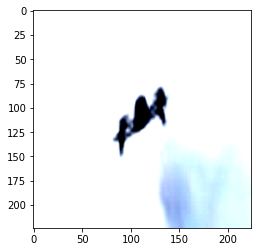

In [38]:
# let's test some random photo from testing data
def inference(test_data):
  idx = torch.randint(1, len(test_data), (1,))
  sample = torch.unsqueeze(test_data[idx][0], dim=0).to(device)

  if torch.sigmoid(model(sample)) < 0.5:
    print("Prediction : Drone")
  else:
    print("Prediction : empty")


  plt.imshow(test_data[idx][0].permute(1, 2, 0))

inference(test_data)

In [ ]:
# keep in mind that this is just experimental and I wanted to see the difference between pytorch and tensorflow.
# predictions could be more accurate if we had more training data, but this is what I've got.
# Currently the rate of false positives is high and could be improved.
# That can be done by introducing more training data, which could include more flying objects and represent the drones better.
# Currently the model will fail to differentiate between drones and birds.